# Rationale Behind the Vorticity Adaptive Sampling

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from PINN import PINN
from GridDataset3D import GridDataset

generator = torch.Generator()
generator.manual_seed(42);

In [44]:
dataset_regular = GridDataset(dir="../../data/Case_01/measurements_flow/postProcessing_BL/winSpeedMapVector/",
                      turbine_csv="../../data/Case_01/measurements_turbines/30000_BL/rot_yaw_combined.csv",
                      wind_csv="../../data/Case_01/winDir_processed.csv", 
                      data_type="wake", 
                      wake_dir="../../data/Case_01/measurements_flow/postProcessing_LuT2deg_internal/winSpeedMapVector/",
                      wake_turbine_csv="../../data/Case_01/measurements_turbines/30000_LuT2deg_internal/rot_yaw_combined.csv",
                      only_grid_values=False)

dataset = GridDataset(dir="../../data/Case_01/measurements_flow/postProcessing_BL/winSpeedMapVector/",
                      turbine_csv="../../data/Case_01/measurements_turbines/30000_BL/rot_yaw_combined.csv",
                      wind_csv="../../data/Case_01/winDir_processed.csv", 
                      data_type="wake", 
                      wake_dir="../../data/Case_01/measurements_flow/postProcessing_LuT2deg_internal/winSpeedMapVector/",
                      wake_turbine_csv="../../data/Case_01/measurements_turbines/30000_LuT2deg_internal/rot_yaw_combined.csv",
                      only_grid_values=False,
                      sampling=True,
                      samples_per_grid=128,
                      top_vorticity=0.85)

sample = 2000
MIN_TIME, MAX_TIME = dataset[0][0][:, 2][0].item(), dataset[-1][0][:, 2][0].item()

inputs, targets = dataset_regular[sample]
samples, _ = dataset[sample]

inputs = inputs.float().cuda(non_blocking=True)
targets = targets.float().cuda(non_blocking=True)
inputs[:, :2] = inputs[:, :2] / 299
inputs[:, 2] = (inputs[:, 2] - MIN_TIME) / MAX_TIME

In [48]:
checkpoint = torch.load(f"models/SiLU128-p1-wake/model300.pt")

model = PINN(in_dimensions=35, hidden_size=128)
model.load_state_dict(checkpoint['model_state_dict'])

model.cuda().eval();

output_field, _ = model(inputs)

output_field = output_field.reshape(300, 300, 5).detach().cpu().permute(1, 0, 2)
targets = targets.reshape(300, 300, 3).detach().cpu()

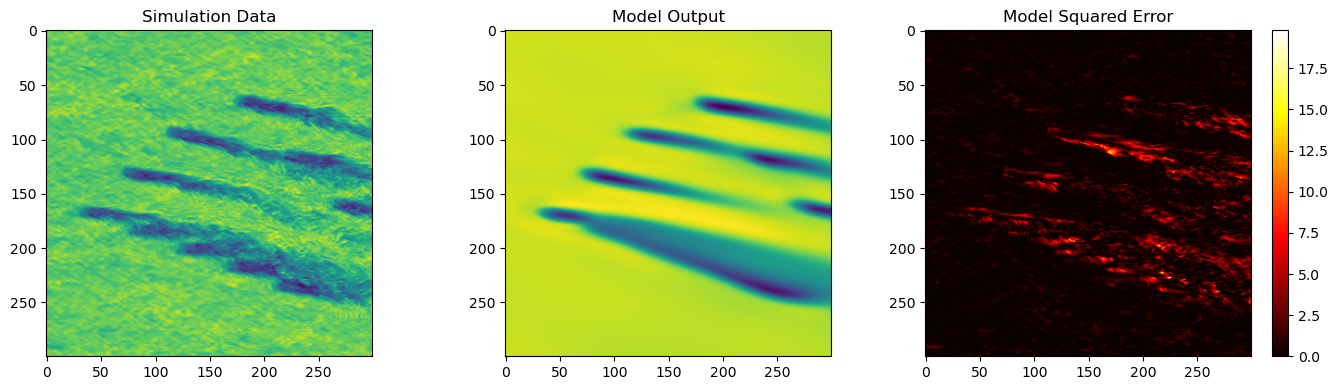

In [49]:
squared_error = (output_field[:, :, 0] - targets[:, :, 0]).pow(2)

fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

ax[0].imshow(targets[:, :, 0])
ax[1].imshow(output_field[:, :, 0])
im = ax[2].imshow(squared_error, cmap='hot')
fig.colorbar(im)

ax[0].set_title("Simulation Data")
ax[1].set_title("Model Output")
ax[2].set_title("Model Squared Error")

fig.tight_layout()

The squared error is high mostly where the wakes are. This is the opposite of what we want. The model seems to not doing so well with areas of high turbulence / high vorticity.

**Idea**: Oversample the places with high vorticity and use it for training.

Let's have a look at how the vorticity looks like over this grid.

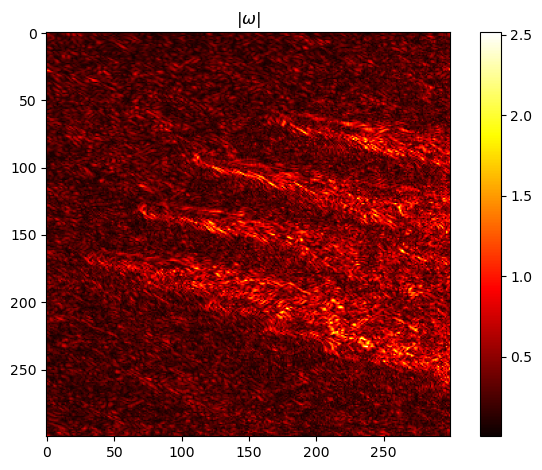

In [50]:
du, dv, dw = torch.gradient(targets[:, :, 0]), torch.gradient(targets[:, :, 1]), torch.gradient(targets[:, :, 2])

dudx, dudy = du[0], du[1]
dvdx, dvdy = dv[0], dv[1]
dwdx, dwdy = dw[0], dw[1]   

x_vorticity = torch.abs(dwdy)
y_vorticity = torch.abs(-dwdx)
z_vorticity = torch.abs(dvdx - dudy)

vorticity = torch.sqrt(x_vorticity ** 2 + y_vorticity **2 + z_vorticity ** 2)

fig, ax = plt.subplots()

im = ax.imshow(vorticity, cmap="hot")
ax.set_title("$|\omega|$")
fig.colorbar(im)

fig.tight_layout()

Let's say we want to target the points with the top 15% vorticity. If we sample uniformly, only 15% of the samples will be in the top 15% vorticity. We want to increase the selection ratio of the top vorticity points such that in the end half our samples come from the top 15% and the other half comes from the rest.

Let's visualize the top 15% vorticity points.

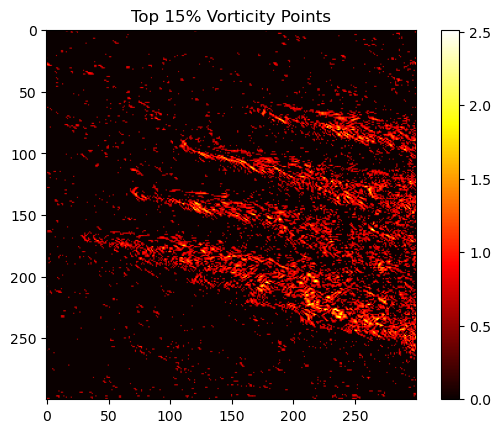

In [51]:
threshold = torch.quantile(vorticity, 0.85)
sparse_vorticity = torch.where(vorticity < threshold, 0, vorticity)

fig, ax = plt.subplots()

im = ax.imshow(sparse_vorticity, cmap="hot")
ax.set_title("Top 15% Vorticity Points")
fig.colorbar(im);

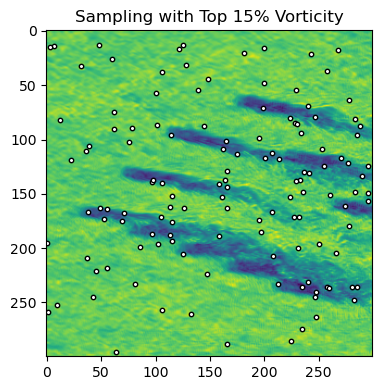

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.imshow(targets[:, :, 0])
ax.scatter(x=samples[:, 0], y=samples[:, 1], color='white', edgecolors='black', s=10)
ax.set_title("Sampling with Top 15% Vorticity")

fig.tight_layout()